In [1]:
from tqdm import tqdm                                  # type: ignore
import numpy as np                                     # type: ignore 
import torch                                           # type: ignore 
import torch.nn as nn                                  # type: ignore                     
import torch.optim as optim                            # type: ignore                 
import torch.utils.data as data                        # type: ignore  
import torchvision   
import torchvision.transforms as transforms            # type: ignore 
import matplotlib.pyplot as plt                        # type: ignore 
        
from medmnist import INFO, Evaluator                   # type: ignore       
from medmnist import BloodMNIST                        # type: ignore

from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # type: ignore

import warnings
warnings.filterwarnings('ignore')  

In [2]:
data_flag = 'bloodmnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = BloodMNIST(split="train", download=False, transform=data_transform)
val_dataset = BloodMNIST(split="val", download=False, transform=data_transform)
test_dataset = BloodMNIST(split="test", download=False, transform=data_transform)

In [4]:
mapping = {0: 'Basófilos', 1: 'Eosinófilos', 2: 'Eritroblastos', 3: 'Granulocitos i.',
           4: 'Linfócitos', 5: 'Monócitos', 6: 'Neutrófilos', 7: 'Plaquetas'}

In [5]:
img_cls = list(mapping.keys())
img_list = []

k = 0
for i in range(1711):
    image, label = train_dataset[i]
    if label[0] == img_cls[k]:
        img_list.append(image)
        k += 1
    
    if k == 8:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


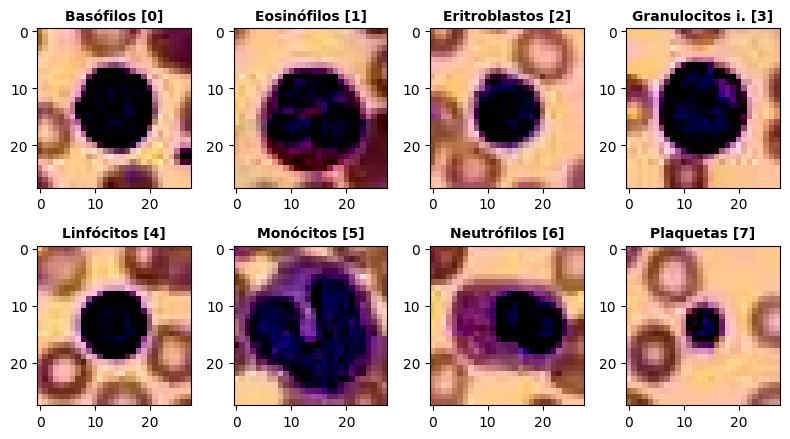

In [6]:
rows, cols = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(8, 4.5), constrained_layout=True)

k = 0
for r in range(rows):
    for c in range(cols):
        ax[r][c].imshow(np.squeeze(img_list[k].permute(1, 2, 0)), aspect="auto")
        ax[r][c].set_title(f"{mapping[k]} [{img_cls[k]}]", fontsize=10, weight='bold')
        
        k += 1
        
plt.tight_layout()
plt.show()

In [7]:
print(f"Size of training: {len(train_dataset)}")
print(f"Size of validation: {len(val_dataset)}")
print(f"Size of testing: {len(test_dataset)}")

Size of training: 11959
Size of validation: 1712
Size of testing: 3421


In [8]:
NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.01

In [9]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

val_loader   = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [10]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = self.layer_stack(x)
        
        return x
    
torch.manual_seed(42)

# Need to setup model with input parameters
model_1 = MultiLayerPerceptron(input_shape=3*784, # one for every pixel (3x28x28)
    hidden_units=128, # how many units in the hidden layer
    output_shape=n_classes # one for every class (8 classes)
)
model_1

MultiLayerPerceptron(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [11]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=0.9)

In [12]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        # calculate log loss probabilities
        outputs = model_1(images)
        
        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
        
        train_total += loss.item()
        
        # zero gradients
        optimizer.zero_grad()        
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0
        
        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in val_loader:
                
                # calculate log loss probabilities
                outputs = model_1(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()
            
                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()
                
        # Calculate average loss between train and test sets
        train_loss = train_total / len(train_loader.dataset)
        val_loss = val_total / len(val_loader.dataset)
        
        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print("Epoch: {}/{}.. ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Val Loss: {:.3f}.. ".format(val_loss),
              "Val Acc: {:.3f}".format(val_correct / len(val_loader.dataset)))
            
end.record()
torch.cuda.synchronize()
print(f'\nFinished Training in {start.elapsed_time(end)/1000} secs')

Epoch: 1/20..  Train Loss: 0.009..  Val Loss: 0.006..  Val Acc: 0.739
Epoch: 2/20..  Train Loss: 0.006..  Val Loss: 0.006..  Val Acc: 0.771
Epoch: 3/20..  Train Loss: 0.005..  Val Loss: 0.005..  Val Acc: 0.774
Epoch: 4/20..  Train Loss: 0.005..  Val Loss: 0.005..  Val Acc: 0.782
Epoch: 5/20..  Train Loss: 0.005..  Val Loss: 0.005..  Val Acc: 0.807
Epoch: 6/20..  Train Loss: 0.005..  Val Loss: 0.005..  Val Acc: 0.798
Epoch: 7/20..  Train Loss: 0.004..  Val Loss: 0.005..  Val Acc: 0.797
Epoch: 8/20..  Train Loss: 0.004..  Val Loss: 0.005..  Val Acc: 0.791
Epoch: 9/20..  Train Loss: 0.004..  Val Loss: 0.004..  Val Acc: 0.806
Epoch: 10/20..  Train Loss: 0.004..  Val Loss: 0.005..  Val Acc: 0.789
Epoch: 11/20..  Train Loss: 0.004..  Val Loss: 0.004..  Val Acc: 0.825
Epoch: 12/20..  Train Loss: 0.004..  Val Loss: 0.004..  Val Acc: 0.822
Epoch: 13/20..  Train Loss: 0.004..  Val Loss: 0.004..  Val Acc: 0.828
Epoch: 14/20..  Train Loss: 0.004..  Val Loss: 0.004..  Val Acc: 0.832
Epoch: 15/20.. 

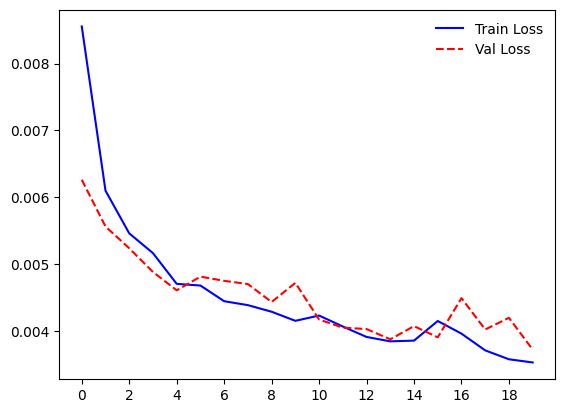

In [13]:
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red', ls='dashed')
plt.legend(frameon=False)
plt.xticks(np.arange(0, 20, 2))
plt.show()

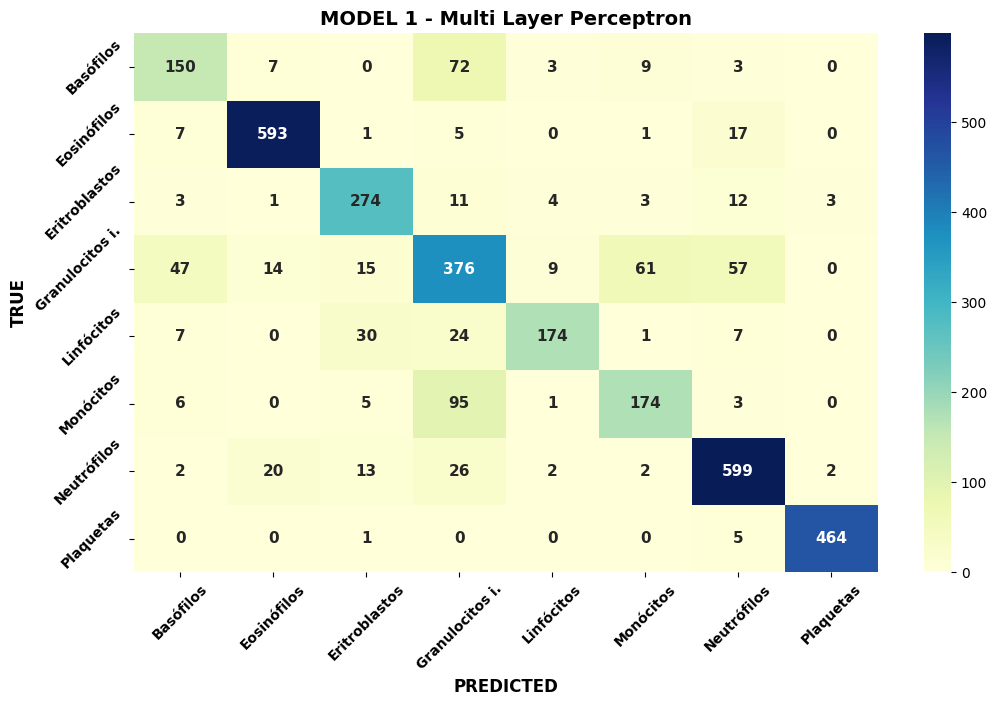

In [14]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
classes = list(mapping.values())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, cmap='YlGnBu', fmt='g', 
           annot_kws={"size": 11, "weight": "bold"})
plt.title('MODEL 1 - Multi Layer Perceptron', weight='bold', fontsize=14)
plt.yticks(rotation=45, weight='bold') 
plt.xticks(rotation=45, weight='bold')
plt.xlabel('PREDICTED', weight='bold', fontsize=12)
plt.ylabel('TRUE', weight='bold', fontsize=12)
plt.show()

In [15]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow((np.squeeze(img.permute(1, 2, 0))))
    #ax1.imshow(img.resize_(3, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax1.set_title(f"{mapping[label.item()]} [{label.item()}]", fontsize=10)
    ax2.barh(np.arange(8), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(8))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(8))
    elif version == "Blood":
        ax2.set_yticklabels(list(mapping.values()), size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


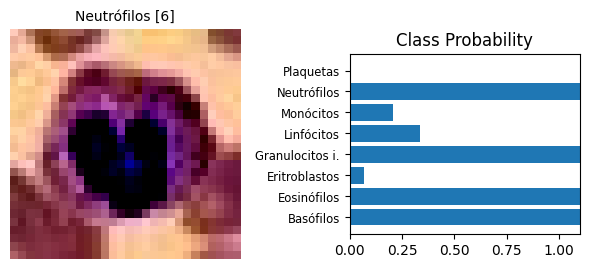

In [16]:
images, labels = next(iter(train_loader))
img = images[0]
label = labels[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784*3)

# Calculate the class probabilities (softmax) for img
ps = torch.exp(model_1(img))

view_classify(img.resize_(3, 28, 28), ps, version='Blood')